# intro

In [2]:
# olympics_heat_stress.ipynb
# written by Milena Raeber, updated 2025-08-05
# this Jupyter notebook recreates figures from "Increasing heat stress risk at the Summer Olympics"

# import packages
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import seaborn as sns
import proplot as pplt

# import data files & functions

In [3]:
# import urban agglomeration (city) population, elevation, and GDP data 
cityinfo = pd.read_csv('./city_info.csv', index_col=0)
citynames = cityinfo.urban_agglomeration.tolist() # list of cities for indexing later

In [4]:
# import olympic games information 
olympicsinfo = pd.read_csv('./olympics_info.csv', header=0)
olynames = ['Los Angeles', 'Seoul', 'Barcelona', 'Atlanta', 'Sydney', 'Athens', 'Beijing', 
            'London', 'Rio de Janeiro'] # list of past host city names

In [5]:
# import sports information (sport class and number of events)
sportsinfo = pd.read_csv('./sports_info.csv', header=0)

In [25]:
# load stats & event suspension probability
histriskstats = xr.open_dataarray('./hist_risk_stats.nc')
histTmaxWtds = xr.open_dataarray('./hist_tmax_prob.nc') 
histTminWtds = xr.open_dataarray('./hist_tmin_prob.nc')
projriskstats = xr.open_dataarray('./proj_risk_stats.nc')
projTmaxWtds = xr.open_dataarray('./proj_tmax_prob.nc') 
projTminWtds = xr.open_dataarray('./proj_tmin_prob.nc')
actcellwtds = xr.open_dataarray('./actual_dates_prob.nc')

In [27]:
# get historical city temperature and humidity from CHC-CMIP6 dataset for historical period (see Williams et al. 2024)
    # needed to create figure 1
# place into xarray dataset object "histcitydata" with dimensions:
    # city: location
    # time: day in historical period 
    # x: longitude of grid cell (10x10 grid around city center was selected)
    # y: latitude (10x10 grid around city center was selected)
# dataset structure below

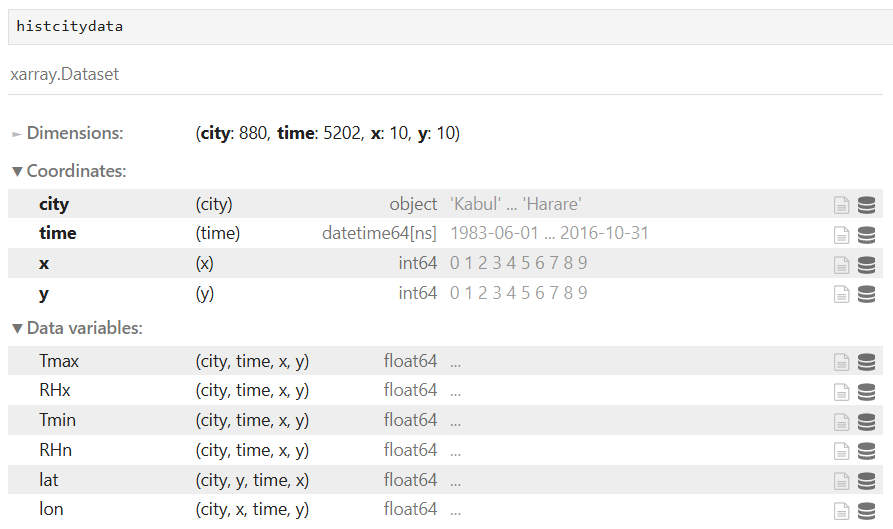

In [7]:
# define function "findcity" to search and return information in city names
def findcity(searchword, database=cityinfo.urban_agglomeration.tolist()):
    """returns the full name (string), index, and country of the urban agglomeration that contains search word"""
    if searchword in database: # if there is an exact match to searchword
        coi = [name for name in database if searchword == name][0] # because list comprehension returns list, get first item
    else: # if no exact hit, get name containing searchword (e.g. London, UK vs. East London, South Africa)
        coi = [name for name in database if searchword in name][0] 
    index = database.index(coi) 
    country = cityinfo.country[index]
    return coi, index, country

# figures

## figure 1

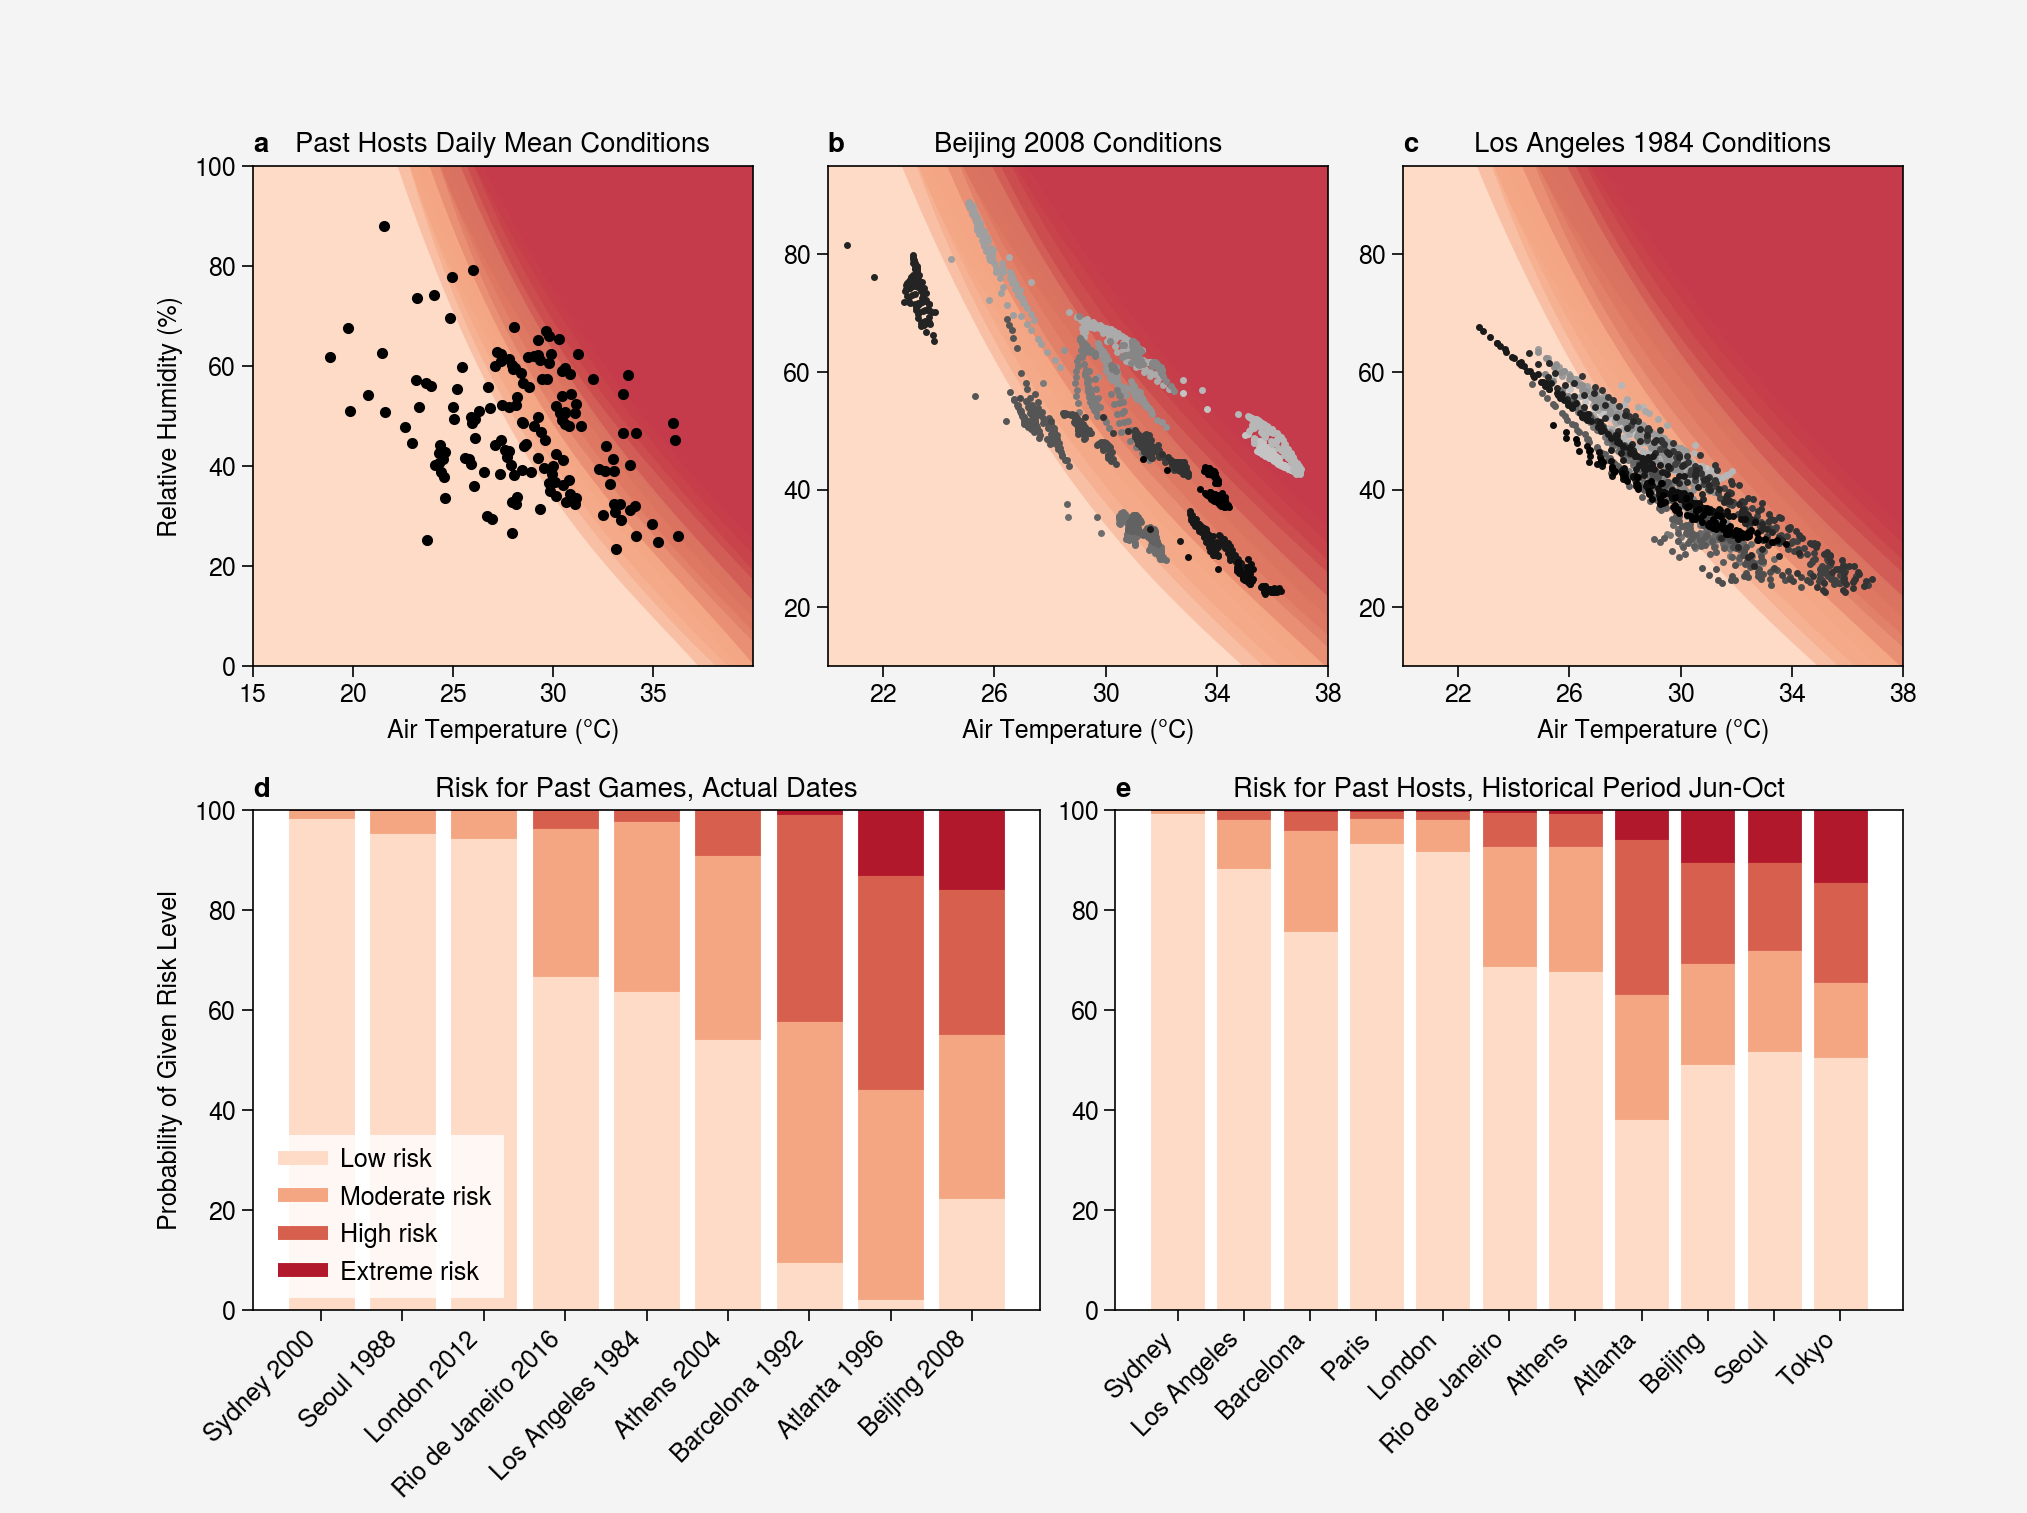

In [26]:
# make figure 1 (historical olympics heat risk)

fig, (ax1,ax2,ax3,ax4,ax5) = pplt.subplots([[1,1,2,2,3,3],[4,4,4,5,5,5]], wratios=[1, 1, 1, 1, 1, 1], 
                                           grid=False, sharex=False, sharey=False, abc=True, 
                                           tight=False, wspace='3em', outerpad=5)

# define equations and variables 
t = np.linspace(10,44,85) # create discrete data

# define heat stress threshold equations (from SMA EHP v1, 2021 via collaborators), in order increasing sport class
modlines = [
    2762.197060579 - 381.325698576*t + 22.540428583*t**2 - 0.686335361*t**3 + 0.010572184*t**4 - 0.000065565*t**5, 
    644.8888653 - 44.76751306*t + 1.217526493*t**2 - 0.01454528912*t**3 + 0.0000511034929*t**4 - 0.00000005655355199*t**5, 
    1329.057632595 - 133.978794488*t + 5.779443747*t**2 - 0.128678801*t**3 + 0.001424576*t**4 - 0.000006184*t**5, 
    2529.053033 - 307.2462383*t + 15.60008067*t**2 - 0.4020859038*t**3 + 0.005155348988*t**4 - 0.0000260736377*t**5, 
    619.6674872 - 34.33489523*t + 0.397665994*t**2 + 0.006672740765*t**3 - 0.00008465613159*t**4 - 0.000001035883342*t**5]
highlines = [
    580.945552430 - 34.947074224*t + 0.861360023*t**2 - 0.012028553*t**3 + 0.000126445*t**4 - 0.000000999*t**5, 
    1380.435016 - 163.3968836*t + 8.904814739*t**2 - 0.2589571348*t**3 + 0.00385268683*t**4 - 0.00002316601231*t**5, 
    1242.422310486 - 116.614628202*t + 4.713012790*t**2 - 0.098192571*t**3 + 0.001011057*t**4 - 0.000004059*t**5, 
    2672.577485 - 308.4117691*t + 14.77650891*t**2 - 0.3567361035*t**3 + 0.004259088881*t**4 - 0.00001997795429*t**5, 
    1005.888581 - 80.0964793*t + 2.514451517*t**2 - 0.03607107452*t**3 + 0.0002050761552*t**4 - 0.0000004017446545*t**5]
extlines = [
    526.925669423 - 26.920742804*t + 0.492041198*t**2 - 0.002914506*t**3 - 0.000009743*t**4 - 0.000000007*t**5, 
    473.5429797 - 21.24738012*t + 0.2565174647*t**2 + 0.001166930518*t**3 - 0.00002760850728*t**4 - 0.0000001532412162*t**5, 
    1507.777139663 - 144.871105781*t + 5.952093868*t**2 - 0.124422329*t**3 + 0.001275952*t**4 - 0.000005083*t**5, 
    1924.803376 - 202.5794044*t + 9.075216103*t**2 - 0.2079575115*t**3 + 0.002383735524*t**4 - 0.00001091572428*t**5, 
    824.4856918 - 56.86097838*t + 1.524176197*t**2 - 0.01765524886*t**3 + 0.00006314005961*t**4 - 0.00000007195002034*t**5]

# define risk colors 
ext_col = '#B50015'
high_col = '#D6604D'
mod_col = '#F4A582'
low_col = '#FDDBC7'

# risk background 
for axi in [ax1, ax2, ax3]: 
    for i in np.arange(0,5,1):
        y1 = extlines[i]
        y_max = 200
        axi.fill_between(t, y1, y_max, color=ext_col, alpha=0.25, edgecolor='none', label='_Hidden') # where=(y_max > y2)
        y1 = highlines[i]
        y2 = extlines[i]
        axi.fill_between(t, y1, y2, where=(y2 > y1), color=high_col, alpha=0.35, edgecolor='none', label='_Hidden')
        y1 = modlines[i]
        y2 = highlines[i]
        axi.fill_between(t, y1, y2, where=(y2 > y1), color=mod_col, alpha=0.5, edgecolor='none', label='_Hidden')
        y_min = -100
        y2 = modlines[i]
        axi.fill_between(t, y1, y_min, where=(y2 > y_min), color=low_col, alpha=1, edgecolor='none', label='_Hidden')

########################################################################

# ax1: hist olympics spread, average space (10x10 grid) and day of Olympics

ax1.set(title='Past Hosts Daily Mean Conditions',
        xlabel='Air Temperature (\u00B0C)', ylabel='Relative Humidity (%)',
        xlim=[15,40], ylim=[0,100])
ax1.format(xtickminor=False, ytickminor=False, xlocator=np.arange(15,36,5))

# loop through games to plot hist data
for gameindex in olympicsinfo.place.index: # loop through games
    startdate = datetime.strptime(olympicsinfo.start_date[gameindex], "%Y-%m-%d").date()
    enddate = datetime.strptime(olympicsinfo.end_date[gameindex], "%Y-%m-%d").date()
    data = histcitydata.sel(city=findcity(olympicsinfo.place[gameindex])[0], time=slice(startdate, enddate))
    for day in range(len(data.time)): # loop through data points in that location
        ax1.plot(data.Tmax[day].mean(), data.RHx[day].mean(), marker='o', color='black', markersize=3, linestyle='None')

########################################################################

# ax2: spread of Beijing 2008 conditions

ax2.set(title='Beijing 2008 Conditions',
        xlabel='Air Temperature (\u00B0C)', ylabel='',
        xlim=[20,38], ylim=[10,95])
ax2.format(xtickminor=False, ytickminor=False, xlocator=np.arange(22,39,4), ylocator=np.arange(20,81,20))

# get data
olyi = 6 # beijing
startdate = datetime.strptime(olympicsinfo.start_date[olyi], "%Y-%m-%d").date()
enddate = datetime.strptime(olympicsinfo.end_date[olyi], "%Y-%m-%d").date()
data = histcitydata.sel(city=findcity(olympicsinfo.place[olyi])[0], time=slice(startdate, enddate))
numdays = len(data.time)

# generate evenly spaced colors
start_color = np.array([196, 196, 196]) # black
end_color = np.array([0, 0, 0]) # light grey
markcolors = ["#{:02X}{:02X}{:02X}".format(*((start_color * (1 - t) + end_color * t).astype(int)))
              for t in np.linspace(0, 1, numdays)]

# plot
for day in range(len(data.time)): # loop through data points in that location
    ax2.plot(data.Tmax[day], data.RHx[day], color=markcolors[day], marker='o', markersize=1.5, linestyle='None')

########################################################################

# ax3: spread of LA 1984 conditions

ax3.set(title='Los Angeles 1984 Conditions',
        xlabel='Air Temperature (\u00B0C)', ylabel='',
        xlim=[20,38], ylim=[10,95])
ax3.format(xtickminor=False, ytickminor=False, xlocator=np.arange(22,39,4), ylocator=np.arange(20,81,20))

# get data
olyi = 0 # LA
startdate = datetime.strptime(olympicsinfo.start_date[olyi], "%Y-%m-%d").date()
enddate = datetime.strptime(olympicsinfo.end_date[olyi], "%Y-%m-%d").date()
data = histcitydata.sel(city=findcity(olympicsinfo.place[olyi])[0], time=slice(startdate, enddate))
numdays = len(data.time)

# generate evenly spaced colors
start_color = np.array([196, 196, 196]) # light grey
end_color = np.array([0, 0, 0]) # black
markcolors = ["#{:02X}{:02X}{:02X}".format(*((start_color * (1 - t) + end_color * t).astype(int)))
              for t in np.linspace(0, 1, numdays)]

# plot
for day in range(len(data.time)): # loop through data points in that location
    ax3.plot(data.Tmax[day], data.RHx[day], color=markcolors[day], marker='o', markersize=1.5, linestyle='None')

########################################################################

# ax4: bar chart of risk at past Olympics during their actual dates

# set solid color palette
solidcolors = ['#FDDBC7', '#F4A582', '#D6604D', '#B2182B', ] # darkest '#67001F'

ax4.set(title='Risk for Past Games, Actual Dates',
        ylabel='Probability of Given Risk Level')

# sort data & plot
sortedActCellWtds = actcellwtds.sortby(actcellwtds.sel(risklevel='lowrisk'), ascending=False).sortby(actcellwtds.sel(risklevel='extrisk'))
sorted_df = pd.DataFrame({'lowrisk': sortedActCellWtds[:,3], 
                          'modrisk': sortedActCellWtds[:,2], 
                          'highrisk': sortedActCellWtds[:,1], 
                          'extrisk': sortedActCellWtds[:,0]})
ax4.bar(sortedActCellWtds.city.data, sorted_df, stack=True, cycle=solidcolors)

ax4.format(ytickminor=False, xrotation=45, 
           xticklabels=['Sydney 2000', 'Seoul 1988', 'London 2012', 'Rio de Janeiro 2016', 'Los Angeles 1984', 
                   'Athens 2004', 'Barcelona 1992','Atlanta 1996', 'Beijing 2008'])

########################################################################

# ax5: bar chart of all historical Jun-Oct risk at 11 host cities

ax5.set(title='Risk for Past Hosts, Historical Period Jun-Oct')
ax5.format(ytickminor=False, xrotation=45)

# get selected city indexes
hostList = ['Sydney', 'Los Angeles', 'Barcelona', 'Paris', 'London', 'Rio de Janeiro', 'Athens', 'Atlanta', 'Beijing', 'Seoul', 'Tokyo'] 
hostidxs = [] # empty index list
for host in hostList: 
    hostidxs.append(findcity(host)[1]) # get index

# sort data & convert to dataframe
sortedHosts = histTmaxWtds.isel(city=hostidxs) # select data for cities
sortedHosts = sortedHosts.sortby(sortedHosts.sel(risklevel='extrisk')) # sort by ext risk, ascending
sorted_df = pd.DataFrame({'lowrisk': sortedHosts[:,3], 
                          'modrisk': sortedHosts[:,2], 
                          'highrisk': sortedHosts[:,1], 
                          'extrisk': sortedHosts[:,0]})
ax5.bar(hostList, sorted_df, stack=True, cycle=solidcolors)
ax4.legend(handles=[plt.Line2D([0], [0], color=solidcolors[0], lw=5),
                    plt.Line2D([0], [0], color=solidcolors[1], lw=5),
                    plt.Line2D([0], [0], color=solidcolors[2], lw=5),
                    plt.Line2D([0], [0], color=solidcolors[3], lw=5)],
           labels=['Low risk', 'Moderate risk', 'High risk', 'Extreme risk'],
           loc='lower left', 
           ncols=1, facecolor='white', edgewidth=0, pad=0.5)

########################################################################

pplt.show()

## figure 2

In [10]:
# data preprocessing: find number of cities that exceed different thresholds

# initialize empty dataframe
exceedThresh = pd.DataFrame(data={'Hist Tmax': np.zeros(5), 'Hist Tmin': np.zeros(5), 'Proj Tmax': np.zeros(5), 'Proj Tmin': np.zeros(5)}, 
                            index=[10, 20, 30, 40, 50])

# loop to fill
for thresh in range(10,51,10):
    exceedThresh['Hist Tmax'][thresh] = np.sum(histTmaxWtds.sel(risklevel='extrisk') > thresh)
    exceedThresh['Proj Tmax'][thresh] = np.sum(projTmaxWtds.sel(risklevel='extrisk') > thresh)
    exceedThresh['Hist Tmin'][thresh] = np.sum(histTminWtds.sel(risklevel='extrisk') > thresh)
    exceedThresh['Proj Tmin'][thresh] = np.sum(projTminWtds.sel(risklevel='extrisk') > thresh)

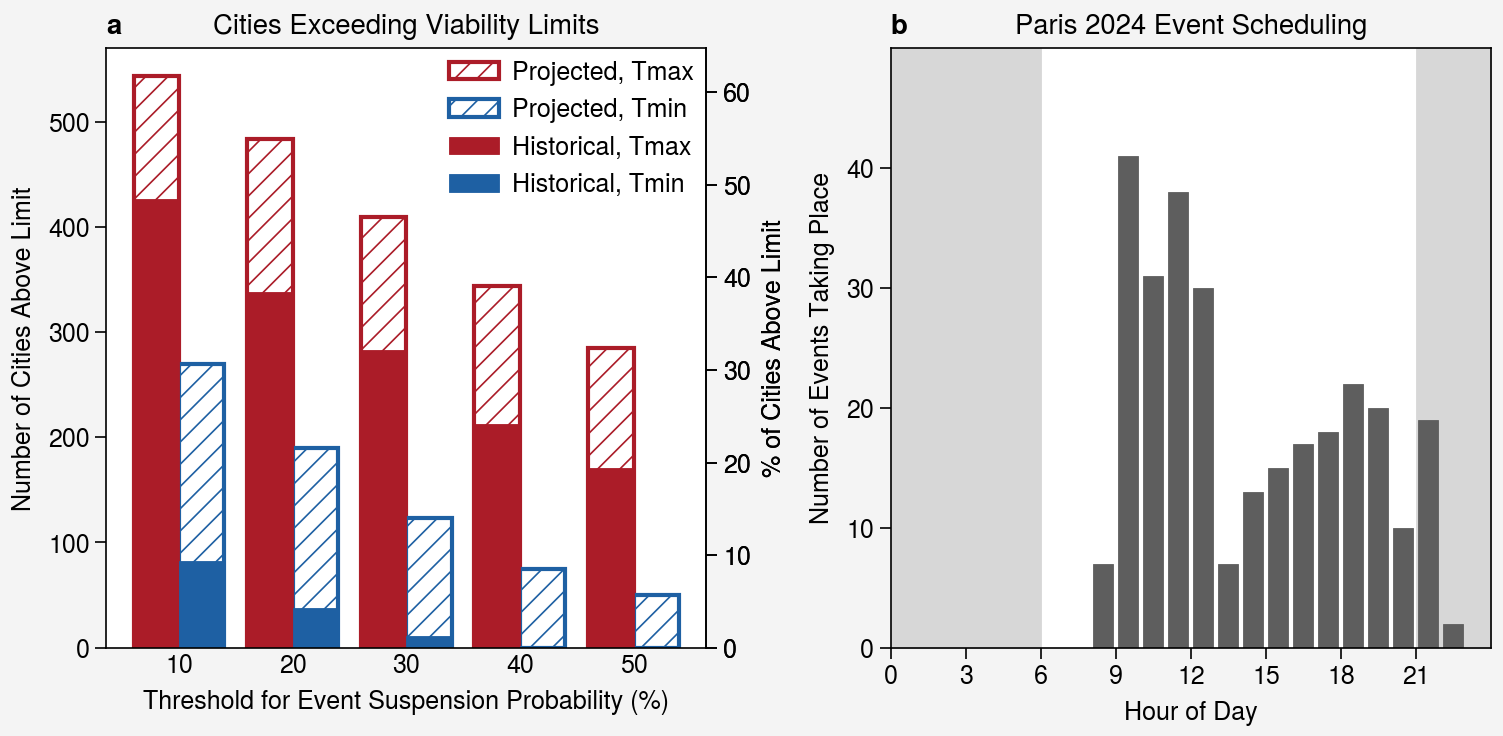

In [11]:
# make figure 2 (sensitivity to viability thresholds and histogram of Paris 2024 schedule)

fig, (ax1,ax2) = pplt.subplots(nrows=1, ncols=2, refwidth=3, refheight=3,
                               grid=False, sharex=False, sharey=False, abc=True) 

# define colors
redc = '#AB1C28'
bluec = '#1E60A3'

########################################################################

# ax1: threshold sensitivity and nonviable cities

ax1.set(title='Cities Exceeding Viability Limits',
        xlabel='Threshold for Event Suspension Probability (%)', ylabel='Number of Cities Above Limit')
ax1.format(xtickminor=False, xticklen=0, ytickminor=False)
ax1.dualy(lambda y: y/880*100,
          label='% of Cities Above Limit', 
          ytickminor=False, grid=False)

# plot bars
ax1.bar(exceedThresh.index.values - 2, exceedThresh['Proj Tmax'], width=0.4,
        color='white', edgecolor=redc, hatch='///', linewidth=1.5, label='Projected, Tmax')
ax1.bar(exceedThresh.index.values + 2, exceedThresh['Proj Tmin'], width=0.4,
        color='white', edgecolor=bluec, hatch='///', linewidth=1.5, label='Projected, Tmin')
ax1.bar(exceedThresh.index.values - 2, exceedThresh['Hist Tmax'], width=0.4,
        color=redc, label='Historical, Tmax')
ax1.bar(exceedThresh.index.values + 2, exceedThresh['Hist Tmin'], width=0.4,
        color=bluec, label='Historical, Tmin')

ax1.legend(ncols=1, loc='upper right', frameon=False)

########################################################################

# ax2: sport event scheduling

ax2.set(title='Paris 2024 Event Scheduling',
        xlabel='Hour of Day', ylabel='Number of Events Taking Place',
        xlim=[7,24])
ax2.format(xtickminor=False, xlocator=range(0,24,3), 
           ytickminor=False, ylocator=np.arange(0,41,10))

# read in paris schedule
schedule = pd.read_csv('./paris_2024_schedule.csv', header=[0,1])

# sort start/end times into hourly bins
bin_counts = np.zeros(24) # initialize bin counts
hours = np.arange(0,24,1)
for row in schedule.index: # loop through dataframe rows
    for col in range(1,schedule.shape[1],2): # loop through columns (days)
        start_time = schedule.iloc[row,col] 
        end_time = schedule.iloc[row,col+1]
        for bin_start in hours: # loop through hours in day, left bin edges
            # count if event starts within 30 mins of and ends at least 30 mins after left bin edge
            if start_time >= bin_start - 0.5 and start_time < bin_start + 0.5 and end_time >= bin_start + 0.5: 
                bin_counts[bin_start] += 1

# plot hours and shade nighttime  
ax2.bar(hours+0.5, bin_counts, color='#5E5E5E')
ax2.format(xlim=(0,24))
ax2.fill_between(range(0,7), 50, color='#D7D7D7')
ax2.fill_between(range(21,25), 50, color='#D7D7D7')

########################################################################

pplt.show()

## figure 3

In [12]:
# data preprocessing: find indices of all past hosts for later

allhosts = ['Athens', 'Paris', 'St. Louis', 'London', 'Stockholm', 'Antwerp', 'Amsterdam', 'Los Angeles', 'Berlin', 
            'Helsinki', 'Melbourne', 'Rome', 'Tokyo', 'Mexico City', 'Munich', 'Montréal', 'Moscow', 'Seoul', 
            'Barcelona', 'Atlanta', 'Sydney', 'Beijing', 'Rio de Janeiro'] # all past hosts (beyond our historical period)

# loop to find indices in histTmaxWtds
hostidxs = [] # initialize empty list
for host in allhosts: 
    hostidxs.append(findcity(host)[1])

/glade/u/home/mraeber/.conda/envs/olympics/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/glade/u/home/mraeber/.conda/envs/olympics/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/glade/u/home/mraeber/.conda/envs/olympics/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


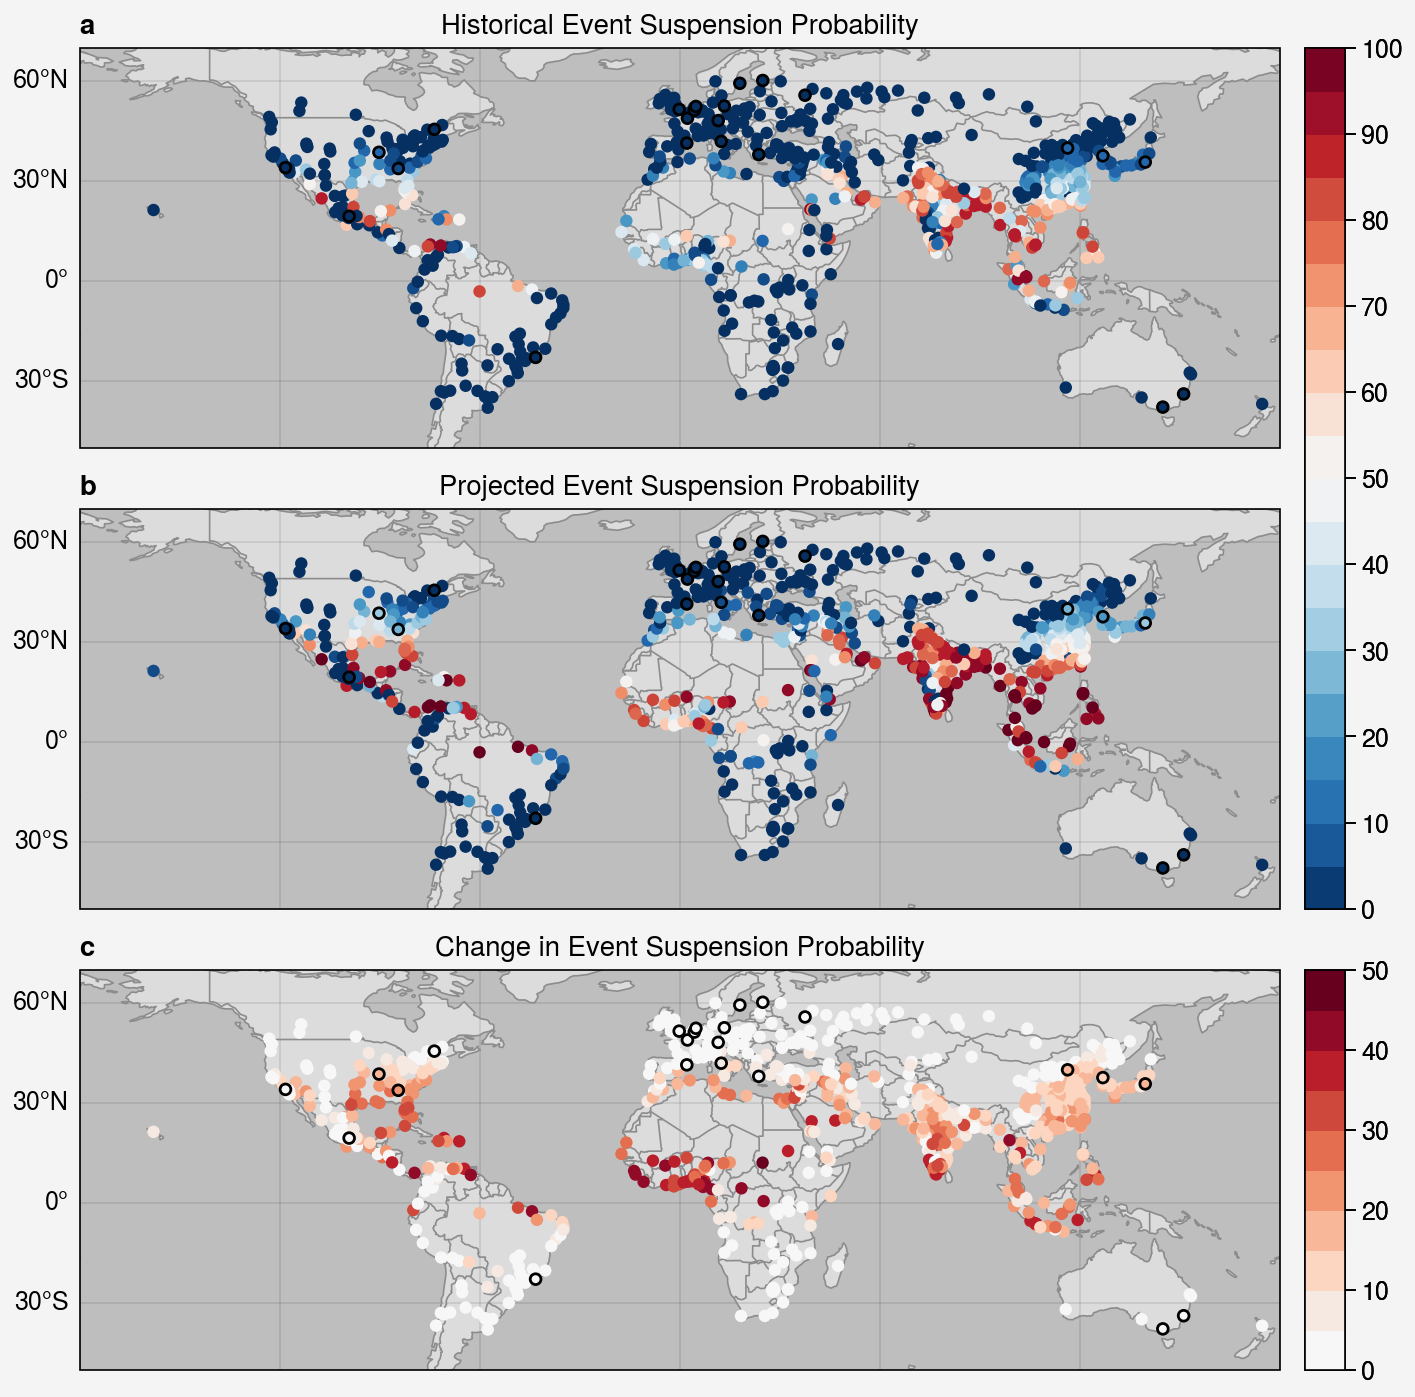

In [13]:
# make figure 3 (event suspension probability maps using Tmax)

fig, (ax1,ax2,ax3) = pplt.subplots(nrows=3, ncols=1, proj=pplt.PlateCarree(), refwidth=6, refheight=2, abc=True)

# map elements
for ax in (ax1,ax2,ax3): 
    ax.format(land=True, landcolor='#DCDCDC', facecolor='#BEBEBE',
              coast=True, coastcolor='#8c8c8c', 
              borders=True, borderscolor='#8c8c8c', innerborderscolor='#8c8c8c', 
              latlocator=[-30, 0, 30, 60], latlabels=True)
    ax.set_extent([-180, 180, -50, 70], crs=ccrs.PlateCarree())

# color management
my_cmap = pplt.Colormap(('#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'), 
                        name='my_cmap')
bounds = np.linspace(0, 100, 21)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=my_cmap.N) # map colormap onto data

########################################################################

# ax1: historical event suspension probability, all cities

ax1.set_title('Historical Event Suspension Probability')

# plot hosts on top in bold
ax1.scatter(cityinfo.lon[hostidxs], cityinfo.lat[hostidxs], c=histTmaxWtds[hostidxs,0], norm=norm, cmap=my_cmap, 
            edgecolor='k', s=15, linewidth=1, zorder=4)

# scatterplot of all cities
ax1.scatter(cityinfo.lon, cityinfo.lat, c=histTmaxWtds[:,0], norm=norm, cmap=my_cmap, s=15, zorder=3)

# colorbar
fig.colorbar(my_cmap, boundaries=bounds, loc='right', rows=(1,2), locator=10)

########################################################################

# ax2: projected event suspension probability, all cities

ax2.set_title('Projected Event Suspension Probability')

# plot hosts on top in bold
ax2.scatter(cityinfo.lon[hostidxs], cityinfo.lat[hostidxs], c=projTmaxWtds[hostidxs,0], norm=norm, cmap=my_cmap, 
            edgecolor='k', s=15, linewidth=1, zorder=4)

# scatterplot of all cities
ax2.scatter(cityinfo.lon, cityinfo.lat, c=projTmaxWtds[:,0], norm=norm, cmap=my_cmap, s=15, zorder=3)

########################################################################

# ax3: difference in projected - historical

ax3.set_title('Change in Event Suspension Probability')

diffcellwtds = projTmaxWtds - histTmaxWtds

# create a difference colormap
diffmap = pplt.Colormap(('#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'), 
                        name='diffmap')
bounds = np.linspace(0, 50, 11)
diffnorm = mcolors.BoundaryNorm(bounds, diffmap.N) 

# plot hosts on top in bold
ax3.scatter(cityinfo.lon[hostidxs], cityinfo.lat[hostidxs], c=diffcellwtds[hostidxs,0], norm=diffnorm, cmap=diffmap,
            edgecolor='k', s=15, linewidth=1, zorder=4)

# make scatterplot of all cities and colorbar
sc3 = ax3.scatter(cityinfo.lon, cityinfo.lat, c=diffcellwtds[:,0], norm=diffnorm, cmap=diffmap, s=15, zorder=3)
fig.colorbar(sc3, loc='right', values=(0,50), row=3, locator=10)

########################################################################

pplt.show()

## figure 4

In [14]:
# data preprocessing: extract elevation and latitude data and separate into projected/historical and viable/nonviable

# define nonviability threshold
thresh = 50 # cities with event suspension probability >50% are nonviable

projExt = projTmaxWtds.sel(risklevel='extrisk') # get extreme risk
histExt = histTmaxWtds.sel(risklevel='extrisk') 

# elevation projected
p_e_via = cityinfo['elev'].where(projExt <= thresh).dropna().to_frame() # select cities
p_e_via = p_e_via.reset_index().drop('index', axis=1) # reset index and drop column
p_e_non = cityinfo['elev'].where(projExt > thresh).dropna().to_frame() # select cities
p_e_non = p_e_non.reset_index().drop('index', axis=1) # reset index and drop column

# elevation historical
h_e_via = cityinfo['elev'].where(histExt <= thresh).dropna().to_frame() # select cities
h_e_via = h_e_via.reset_index().drop('index', axis=1) # reset index and drop column
h_e_non = cityinfo['elev'].where(histExt > thresh).dropna().to_frame() # select cities
h_e_non = h_e_non.reset_index().drop('index', axis=1) # reset index and drop column

# latitude projected
p_l_via = cityinfo['lat'].where(projExt <= thresh).dropna().to_frame() # select cities
p_l_via = p_l_via.reset_index().drop('index', axis=1) # reset index and drop column
p_l_non = cityinfo['lat'].where(projExt > thresh).dropna().to_frame() # select cities
p_l_non = p_l_non.reset_index().drop('index', axis=1) # reset index and drop column

# latitude hist
h_l_via = cityinfo['lat'].where(histExt <= thresh).dropna().to_frame() # select cities
h_l_via = h_l_via.reset_index().drop('index', axis=1) # reset index and drop column
h_l_non = cityinfo['lat'].where(histExt > thresh).dropna().to_frame() # select cities
h_l_non = h_l_non.reset_index().drop('index', axis=1) # reset index and drop column

# gdp proj
p_g_via = cityinfo['GDP'].where(projExt <= thresh).dropna().to_frame() # select cities
p_g_via = p_g_via.reset_index().drop('index', axis=1) # reset index and drop column
p_g_non = cityinfo['GDP'].where(projExt > thresh).dropna().to_frame() # select cities
p_g_non = p_g_non.reset_index().drop('index', axis=1) # reset index and drop column

# gdp hist
h_g_via = cityinfo['GDP'].where(histExt <= thresh).dropna().to_frame() # select cities
h_g_via = h_g_via.reset_index().drop('index', axis=1) # reset index and drop column
h_g_non = cityinfo['GDP'].where(histExt > thresh).dropna().to_frame() # select cities
h_g_non = h_g_non.reset_index().drop('index', axis=1) # reset index and drop column

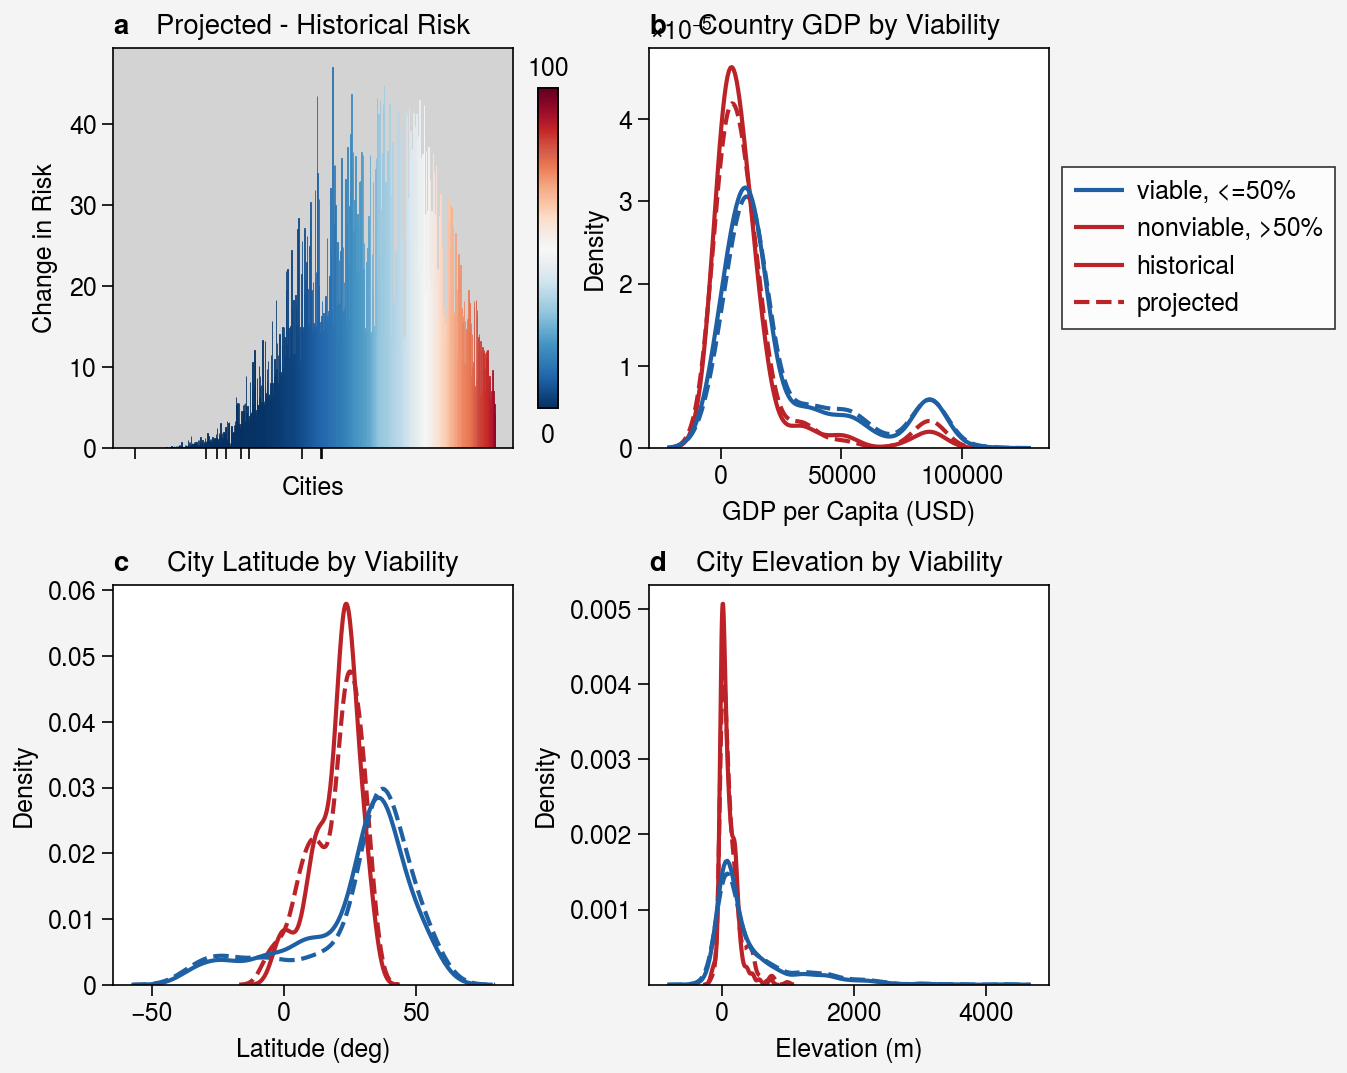

In [15]:
# make figure 4 (elevation and latitude by viability)

fig, (ax1,ax2,ax3,ax4) = pplt.subplots(nrows=2, ncols=2, grid=False, sharex=False, sharey=False, abc=True, refheight=2)

# define colors
redc = '#BC2328'
bluec = '#1E60A3'

########################################################################

# ax1: difference bar chart

# extract data and sort
histExt = histTmaxWtds.sel(risklevel='extrisk') 
sortedHistExt = histExt.sortby(histExt) 
projExt = projTmaxWtds.sel(risklevel='extrisk') # get extreme risk
sortedProjExt = projExt.sortby(histExt) # sort by same data to align order

diffExt = projExt - histExt # calculate difference

# color control
barcmap = pplt.Colormap('my_cmap') # needs maps to run first
barnorm = pplt.Normalize(0, 100)
mappable = plt.cm.ScalarMappable(cmap=barcmap, norm=barnorm)
barcolors = barcmap(barnorm(sortedHistExt))

# set up for host tick marks
sortidxs = []
for host in olympicsinfo.place: 
    sortidxs.append(findcity(host,list(sortedProjExt.city.data))[1])

# plot
ax1.bar(sortedProjExt.city, sortedProjExt-sortedHistExt, color=barcolors, width=1) 
ax1.set(title='Projected - Historical Risk', xlabel='Cities', ylabel='Change in Risk')
ax1.set_xticks([])
ax1.format(ytickminor=False, facecolor='lightgray',
           xlocator=sortidxs, xticklabels=[])

# add colorbar
cbar = ax1.colorbar(mappable, loc='r', ticks=[], width=0.1, length=0.8, space='1em')
ax1.text(0.5, 1.02, '100', ha='center', va='bottom', transform=cbar.ax.transAxes)
ax1.text(0.5, -0.05, '0', ha='center', va='top', transform=cbar.ax.transAxes)

########################################################################

# ax2: GDP

sns.kdeplot(np.array(p_g_non), ax=ax2, palette=[redc], legend=False, linestyle='--')
sns.kdeplot(np.array(p_g_via), ax=ax2, palette=[bluec], legend=False, linestyle='--')
sns.kdeplot(np.array(h_g_non), ax=ax2, palette=[redc], legend=False)
sns.kdeplot(np.array(h_g_via), ax=ax2, palette=[bluec], legend=False)
ax2.set(title='Country GDP by Viability', xlabel='GDP per Capita (USD)')
ax2.format(xtickminor=False, ytickminor=False)

ax2.legend(loc='right', ncols=1, 
           handles=[plt.Line2D([0], [0], color=bluec), plt.Line2D([0], [0], color=redc), 
                    plt.Line2D([0], [0], color=redc), plt.Line2D([0], [0], color=redc, linestyle='--')],
           labels=[f'viable, <={thresh}%',f'nonviable, >{thresh}%', 'historical', 'projected'])

########################################################################

# ax3: latitude

sns.kdeplot(np.array(p_l_non), ax=ax3, palette=[redc], legend=False, linestyle='--')
sns.kdeplot(np.array(p_l_via), ax=ax3, palette=[bluec], legend=False, linestyle='--')
sns.kdeplot(np.array(h_l_non), ax=ax3, palette=[redc], legend=False)
sns.kdeplot(np.array(h_l_via), ax=ax3, palette=[bluec], legend=False)
ax3.set(title='City Latitude by Viability', xlabel='Latitude (deg)')
ax3.format(xtickminor=False, ytickminor=False)

########################################################################

# ax4: elevation 

sns.kdeplot(np.array(p_e_non), ax=ax4, palette=[redc], bw_adjust=.75, legend=False, linestyle='--')
sns.kdeplot(np.array(p_e_via), ax=ax4, palette=[bluec], bw_adjust=.75, legend=False, linestyle='--')
sns.kdeplot(np.array(h_e_non), ax=ax4, palette=[redc], bw_adjust=.75, legend=False)
sns.kdeplot(np.array(h_e_via), ax=ax4, palette=[bluec], bw_adjust=.75, legend=False)
ax4.set(title='City Elevation by Viability', xlabel='Elevation (m)')
ax4.format(xtickminor=False, ytickminor=False, yticks=[0.001,0.002,0.003,0.004,0.005])

########################################################################

pplt.show()

## figure s1

/glade/u/home/mraeber/.conda/envs/olympics/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/glade/u/home/mraeber/.conda/envs/olympics/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/glade/u/home/mraeber/.conda/envs/olympics/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


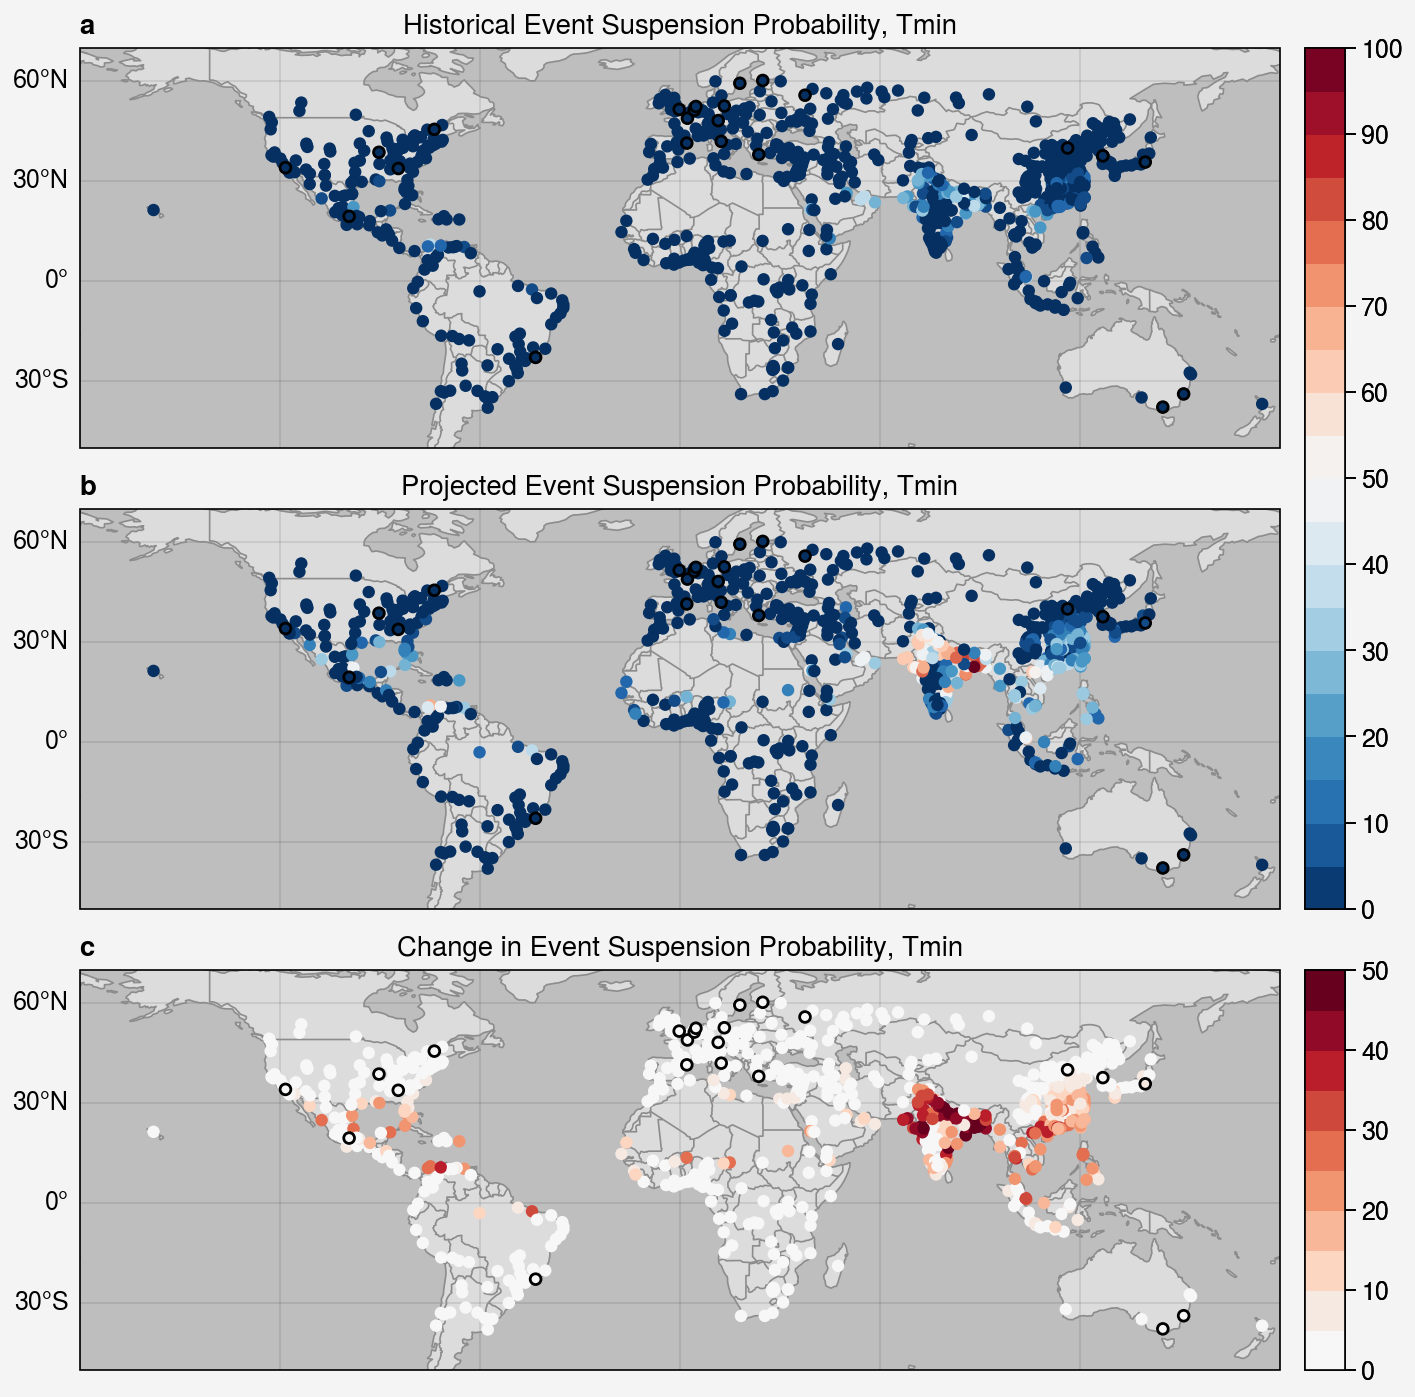

In [16]:
# make figure s1 (event suspension probability maps using Tmin)

fig, (ax1,ax2,ax3) = pplt.subplots(nrows=3, ncols=1, proj=pplt.PlateCarree(), refwidth=6, refheight=2, abc=True)

for ax in (ax1,ax2,ax3): 
    ax.format(land=True, landcolor='#DCDCDC', facecolor='#BEBEBE',
              coast=True, coastcolor='#8c8c8c', 
              borders=True, borderscolor='#8c8c8c', innerborderscolor='#8c8c8c', 
              latlocator=[-30, 0, 30, 60], latlabels=True)
    ax.set_extent([-180, 180, -50, 70], crs=ccrs.PlateCarree())

# color management
my_cmap = pplt.Colormap(('#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'), 
                        name='my_cmap')
bounds = np.linspace(0, 100, 21)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=my_cmap.N) # map onto data

########################################################################

# ax1: historical prob ev sus, all cities

ax1.set_title('Historical Event Suspension Probability, Tmin')

# plot hosts on top
ax1.scatter(cityinfo.lon[hostidxs], cityinfo.lat[hostidxs], c=histTminWtds[hostidxs,0], norm=norm, cmap=my_cmap, 
            edgecolor='k', s=15, linewidth=1, zorder=4)

# scatterplot
ax1.scatter(cityinfo.lon, cityinfo.lat, c=histTminWtds[:,0], norm=norm, cmap=my_cmap, s=15, zorder=3)

# colorbar
fig.colorbar(my_cmap, boundaries=bounds, loc='right', rows=(1,2), locator=10)

########################################################################

# ax2: projected prob ev sus, all cities

ax2.set_title('Projected Event Suspension Probability, Tmin')

# plot hosts on top
ax2.scatter(cityinfo.lon[hostidxs], cityinfo.lat[hostidxs], c=projTminWtds[hostidxs,0], norm=norm, cmap=my_cmap, 
            edgecolor='k', s=15, linewidth=1, zorder=4)

# scatterplot
ax2.scatter(cityinfo.lon, cityinfo.lat, c=projTminWtds[:,0], norm=norm, cmap=my_cmap, s=15, zorder=3)

########################################################################

# ax3 map: difference proj - hist

ax3.set_title('Change in Event Suspension Probability, Tmin')

difftmin = projTminWtds - histTminWtds

# create a continuous colormap from matplotlib colors
diffmap = pplt.Colormap(('#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'), 
                        name='diffmap')
bounds = np.linspace(0, 50, 11)
diffnorm = mcolors.BoundaryNorm(bounds, diffmap.N) 

# plot hosts on top
ax3.scatter(cityinfo.lon[hostidxs], cityinfo.lat[hostidxs], c=difftmin[hostidxs,0], norm=diffnorm, cmap=diffmap,
            edgecolor='k', s=15, linewidth=1, zorder=4)

# make scatterplot and colorbar
sc3 = ax3.scatter(cityinfo.lon, cityinfo.lat, c=difftmin[:,0], norm=diffnorm, cmap=diffmap, s=15, zorder=3)
fig.colorbar(sc3, loc='right', values=(0,50), row=3, locator=10)

########################################################################

pplt.show()

## figure s2

In [18]:
# data preprocessing: find max historical risk across time in past hosts by sport class 

# find names in dataset
cityidxs = [] # find indices
for game in olynames:
    cityidxs.append(findcity(game)[1])

# select historical extreme risk data, all time, past hosts
pastGames = histriskstats.isel(city=cityidxs) 
pastGames = pastGames.sel(sport=['athletics','golf','tennis','equestrian','hockey'], risklevel='extrisk', stat='probability')

# loop to find maximum event suspension probablity experienced for each sport class
pastRisks = []
for sport in ['athletics','golf','tennis','equestrian','hockey']: # use on from each sport class 1-5
    pastRisks.append(pastGames.sel(sport=sport).data.max())

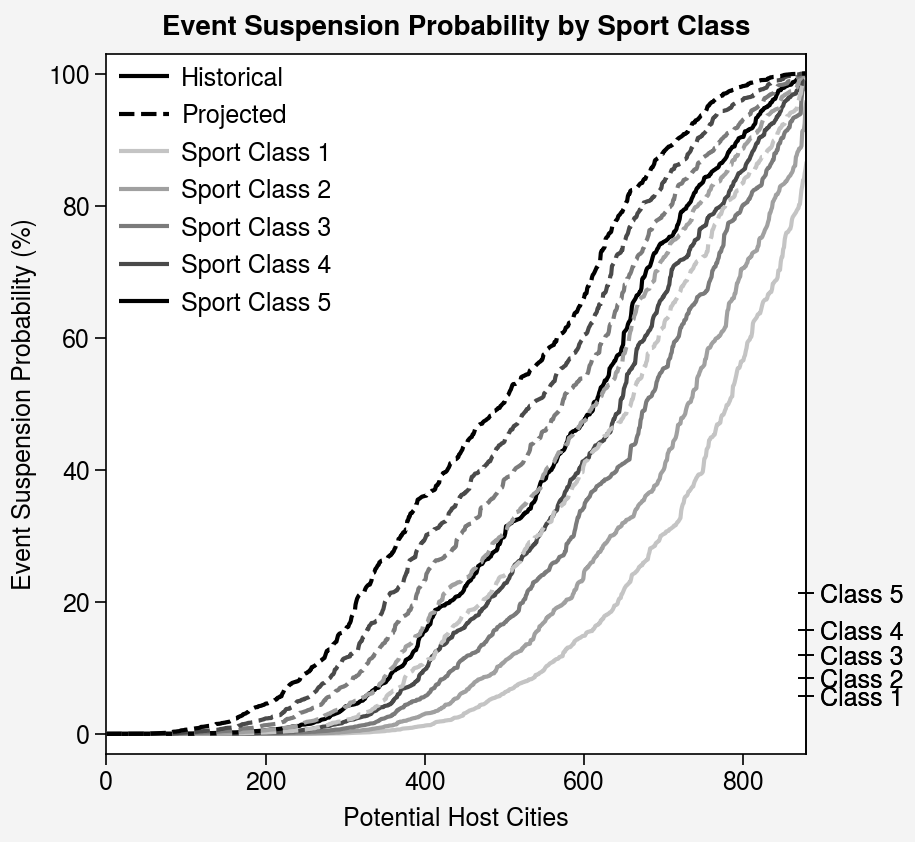

In [21]:
# make figure s2: risk by sport class for all cities

fig, ax = pplt.subplots(refwidth=3.5, refheight=3.5, grid=False, suptitle='Event Suspension Probability by Sport Class')

# select data for one sport in each sport class
sportClassRepsHist = histriskstats.sel(sport=['athletics','golf','tennis','equestrian','hockey'], stat='probability', risklevel='extrisk')
sportClassRepsProj = projriskstats.sel(sport=['athletics','golf','tennis','equestrian','hockey'], stat='probability', risklevel='extrisk')

greys = ['#C4C4C4', '#A0A0A0', '#7B7B7B', '#4A4A4A', '#000000']

# plot risk histogram lines
for index in range(0,5):
    sortedHist = sportClassRepsHist.isel(sport=index).sortby(sportClassRepsHist.isel(sport=index), ascending=True)
    sortedProj = sportClassRepsProj.isel(sport=index).sortby(sportClassRepsProj.isel(sport=index), ascending=True)
    ax.plot(sortedHist.city, sortedHist, color=greys[index])
    ax.plot(sortedProj.city, sortedProj, color=greys[index], ls='dashed', zorder=5)

# add tick marks for past risk
axtick = ax.twinx()
axtick.format(ylim=(-3,103),
              ylocator=pastRisks,
              yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],
              ytickdir='inout',
              yticklen=6,
              ytickminor=False, 
              ygrid=False)

ax.set_xlabel('Potential Host Cities')
ax.set_ylabel('Event Suspension Probability (%)')
ax.format(ylim=(-3,103), ytickminor=False,
          xlocator=list(range(0,880,200)),
          xticklabels=['0', '200', '400', '600', '800'],
          xtickminor=False)

ax.legend(handles=[plt.Line2D([0], [0], color='#000000'), plt.Line2D([0], [0], color='#000000', ls='dashed'),
                   plt.Line2D([0], [0], color='#C4C4C4'), plt.Line2D([0], [0], color='#A0A0A0'), plt.Line2D([0], [0], color='#7B7B7B'), 
                   plt.Line2D([0], [0], color='#4A4A4A'), plt.Line2D([0], [0], color='#000000')],
          labels=['Historical', 'Projected', 'Sport Class 1','Sport Class 2', 'Sport Class 3', 'Sport Class 4', 'Sport Class 5'],
          loc='upper left', ncols=1, frameon=False)

pplt.show()